In [41]:
! pip install torch torchvision torchaudio torchinfo opencv-python-headless tqdm

In [77]:
# Codeblock 1
import os
import cv2
#import opencv-python-headless
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader

In [78]:
# Codeblock 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [79]:
# Codeblock 3
def load_images(path):

    images = []
    filenames = os.listdir(path)
    
    for filename in tqdm(filenames): 
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    
    return np.array(images)

def load_image_from_s3(bucket, key, region_name='eu-central-1'):
    """
    MKL: new function - needs to read all from S3 - similar to load_images
    """
        
    s3 = boto3.resource('s3', region_name='eu-central-1')
    bucket = s3.Bucket(bucket)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)



In [80]:
# Codeblock 5
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(100, 100, 100, 3)
(100, 100, 100, 3)
(50, 100, 100, 3)
(50, 100, 100, 3)


In [1]:
# Codeblock 4
#Load Images & Create Labels
cats_train = load_images('/home/cdsw/archive_small/training_set/cats')
dogs_train = load_images('/home/cdsw/archive_small/training_set/dogs')
#cats_train = load_images_from_s3('s3://mklein-cdp/classification-demo/training_set/cats/')
#dogs_train = load_images_from_s3('s3://mklein-cdp/classification-demo/training_set/dogs/')



cats_test = load_images('/home/cdsw/archive_small/test_set/cats')
dogs_test = load_images('/home/cdsw/archive_small/test_set/dogs')
#cats_test = load_images_from_s3('s3://mklein-cdp/classification-demo/test_set/cats/')
#dogs_test = load_images_from_s3('s3://mklein-cdp/classification-demo/test_set/dogs/')

NameError: name 'load_images_from_s3' is not defined

In [83]:
# Codeblock 6
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(200, 100, 100, 3)
(100, 100, 100, 3)


In [84]:
# Codeblock 7
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(200,)
(100,)


In [85]:
# Codeblock 8
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

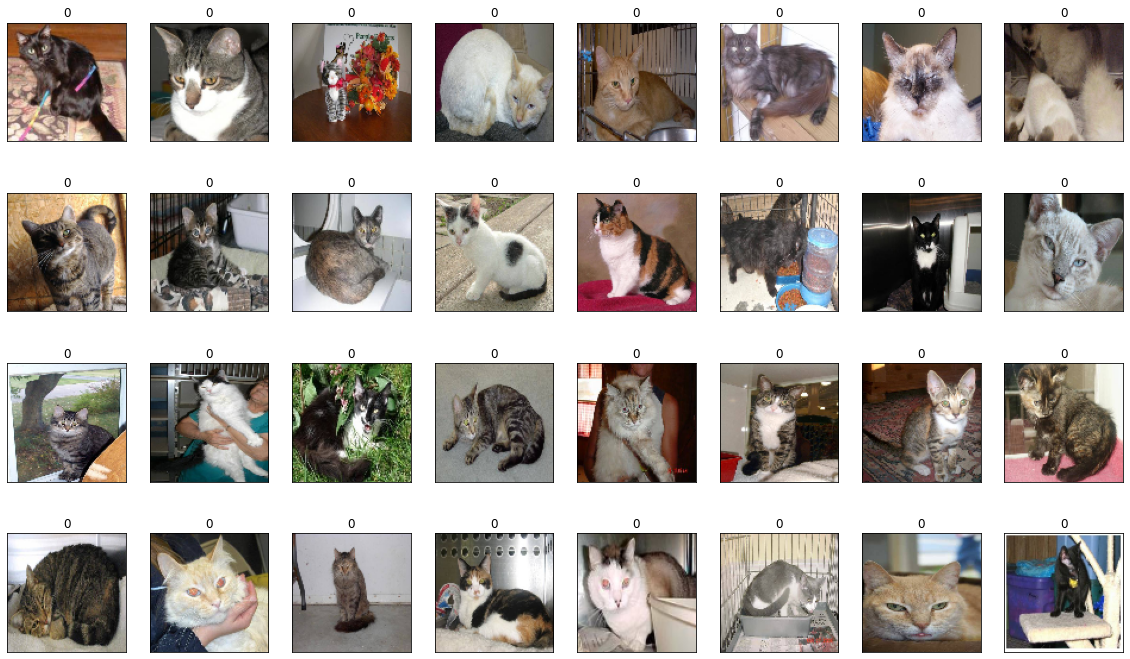

In [86]:
# Codeblock 9
show_images(X_train, y_train, 0)

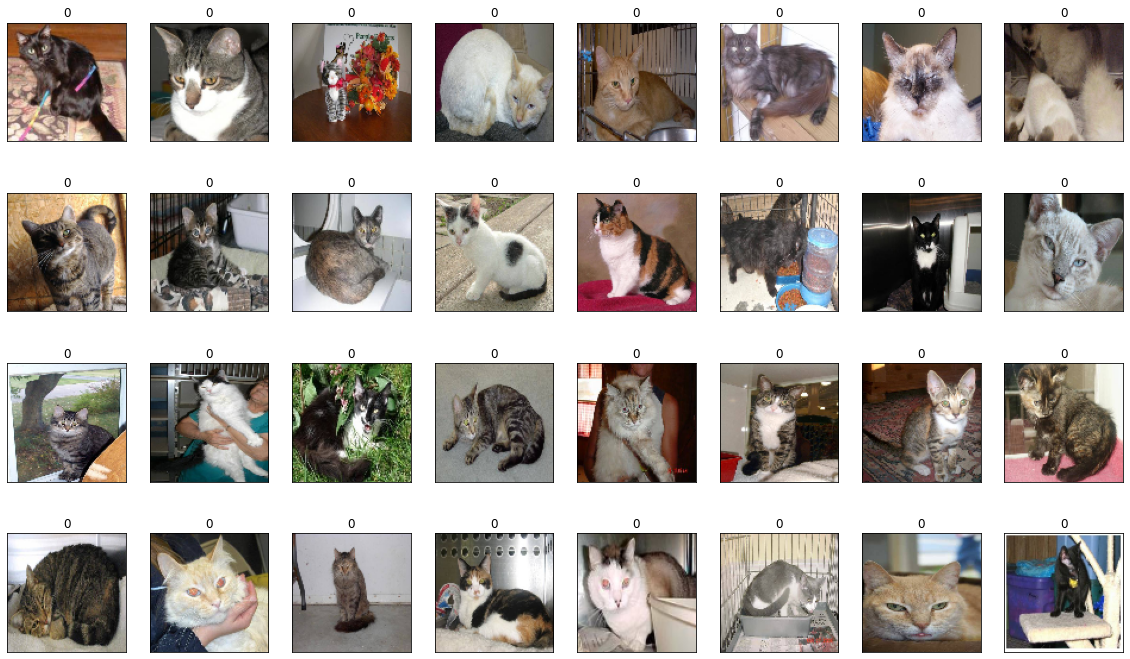

In [87]:
# Codeblock 10
#show_images(X_train, y_train, 4000)
show_images(X_train, y_train, 0)


In [91]:
# Codeblock 11
print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [92]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))

print(y_train[:10])

TypeError: expected np.ndarray (got Tensor)

In [93]:
# Codeblock 13
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20), 
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.RandomVerticalFlip(p=0.005), 
                                       transforms.RandomGrayscale(p=0.2), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [55]:
# Codeblock 14
transforms_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [56]:
# Codeblock 15
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

In [57]:
# Codeblock 16
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [58]:
# Codeblock 17
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [59]:
# Codeblock 18
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


torch.Size([32, 100, 100, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

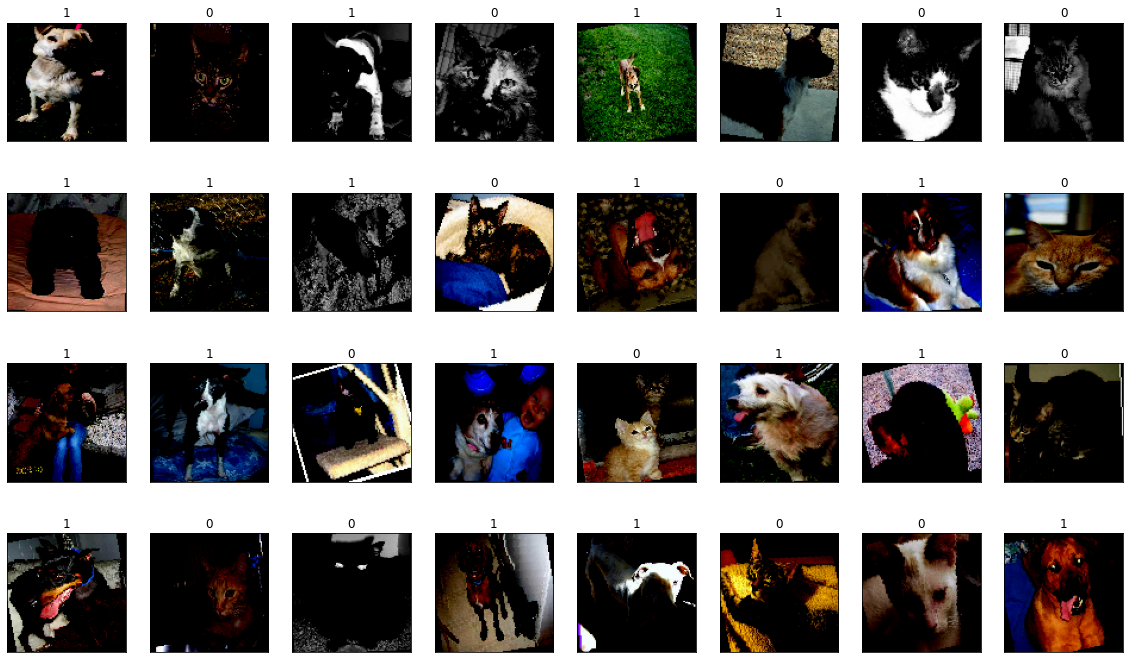

In [60]:
# Codeblock 19
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

In [61]:
# Codeblock 20
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # self.maxpool
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # self.maxpool
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # self.maxpool
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128*6*6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        return x

In [62]:
# Codeblock 21
model = CNN().to(device)

In [63]:
# Codeblock 22
summary(model, input_size=(4,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [4, 1]                    --
├─Conv2d: 1-1                            [4, 16, 100, 100]         432
├─BatchNorm2d: 1-2                       [4, 16, 100, 100]         32
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           --
├─Conv2d: 1-4                            [4, 32, 50, 50]           4,608
├─BatchNorm2d: 1-5                       [4, 32, 50, 50]           64
├─MaxPool2d: 1-6                         [4, 32, 25, 25]           --
├─Conv2d: 1-7                            [4, 64, 25, 25]           18,432
├─BatchNorm2d: 1-8                       [4, 64, 25, 25]           128
├─MaxPool2d: 1-9                         [4, 64, 12, 12]           --
├─Conv2d: 1-10                           [4, 128, 12, 12]          73,728
├─BatchNorm2d: 1-11                      [4, 128, 12, 12]          256
├─MaxPool2d: 1-12                        [4, 128, 6, 6]            --
├

In [64]:
# Codeblock 23
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
# Codeblock 24
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

In [66]:
# Codeblock 25

train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []

for epoch in range(100):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        
        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)
        
        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)
            
        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s]


Epoch: 0 	| Train loss: 0.726 	| Test loss: 0.713 	| Train acc: 0.55 	| Test acc: 0.5


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.85it/s]


Epoch: 1 	| Train loss: 0.757 	| Test loss: 0.678 	| Train acc: 0.53 	| Test acc: 0.49


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.69it/s]


Epoch: 2 	| Train loss: 0.657 	| Test loss: 0.685 	| Train acc: 0.6 	| Test acc: 0.5


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.96it/s]


Epoch: 3 	| Train loss: 0.518 	| Test loss: 0.759 	| Train acc: 0.68 	| Test acc: 0.51


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.27it/s]


Epoch: 4 	| Train loss: 0.676 	| Test loss: 0.8 	| Train acc: 0.63 	| Test acc: 0.5


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s]


Epoch: 5 	| Train loss: 0.645 	| Test loss: 0.73 	| Train acc: 0.71 	| Test acc: 0.57


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.89it/s]


Epoch: 6 	| Train loss: 0.433 	| Test loss: 0.679 	| Train acc: 0.72 	| Test acc: 0.61


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.79it/s]


Epoch: 7 	| Train loss: 0.566 	| Test loss: 0.641 	| Train acc: 0.71 	| Test acc: 0.59


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.45it/s]


Epoch: 8 	| Train loss: 0.578 	| Test loss: 0.805 	| Train acc: 0.78 	| Test acc: 0.62


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.88it/s]


Epoch: 9 	| Train loss: 0.631 	| Test loss: 0.691 	| Train acc: 0.73 	| Test acc: 0.65


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.57it/s]


Epoch: 10 	| Train loss: 0.566 	| Test loss: 0.523 	| Train acc: 0.77 	| Test acc: 0.58


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.20it/s]


Epoch: 11 	| Train loss: 0.508 	| Test loss: 0.812 	| Train acc: 0.78 	| Test acc: 0.62


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.05it/s]


Epoch: 12 	| Train loss: 0.3 	| Test loss: 1.071 	| Train acc: 0.79 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.56it/s]


Epoch: 13 	| Train loss: 0.595 	| Test loss: 0.72 	| Train acc: 0.84 	| Test acc: 0.62


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s]


Epoch: 14 	| Train loss: 0.448 	| Test loss: 0.782 	| Train acc: 0.81 	| Test acc: 0.61


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.78it/s]


Epoch: 15 	| Train loss: 0.655 	| Test loss: 0.775 	| Train acc: 0.76 	| Test acc: 0.62


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.92it/s]


Epoch: 16 	| Train loss: 0.336 	| Test loss: 0.883 	| Train acc: 0.83 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.92it/s]


Epoch: 17 	| Train loss: 0.408 	| Test loss: 1.052 	| Train acc: 0.85 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s]


Epoch: 18 	| Train loss: 0.378 	| Test loss: 0.825 	| Train acc: 0.84 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.66it/s]


Epoch: 19 	| Train loss: 0.401 	| Test loss: 0.876 	| Train acc: 0.89 	| Test acc: 0.7


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s]


Epoch: 20 	| Train loss: 0.33 	| Test loss: 0.875 	| Train acc: 0.84 	| Test acc: 0.66


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.07it/s]


Epoch: 21 	| Train loss: 0.313 	| Test loss: 0.614 	| Train acc: 0.84 	| Test acc: 0.66


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s]


Epoch: 22 	| Train loss: 0.427 	| Test loss: 0.727 	| Train acc: 0.85 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s]


Epoch: 23 	| Train loss: 0.385 	| Test loss: 0.83 	| Train acc: 0.87 	| Test acc: 0.66


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.74it/s]


Epoch: 24 	| Train loss: 0.233 	| Test loss: 0.506 	| Train acc: 0.85 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.65it/s]


Epoch: 25 	| Train loss: 0.597 	| Test loss: 0.956 	| Train acc: 0.85 	| Test acc: 0.69


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s]


Epoch: 26 	| Train loss: 0.382 	| Test loss: 1.094 	| Train acc: 0.85 	| Test acc: 0.64


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s]


Epoch: 27 	| Train loss: 0.297 	| Test loss: 0.799 	| Train acc: 0.88 	| Test acc: 0.64


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.66it/s]


Epoch: 28 	| Train loss: 0.262 	| Test loss: 0.381 	| Train acc: 0.91 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s]


Epoch: 29 	| Train loss: 0.213 	| Test loss: 0.595 	| Train acc: 0.93 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.69it/s]


Epoch: 30 	| Train loss: 0.105 	| Test loss: 1.069 	| Train acc: 0.92 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.43it/s]


Epoch: 31 	| Train loss: 0.195 	| Test loss: 0.66 	| Train acc: 0.93 	| Test acc: 0.76


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s]


Epoch: 32 	| Train loss: 0.126 	| Test loss: 0.659 	| Train acc: 0.95 	| Test acc: 0.65


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.89it/s]


Epoch: 33 	| Train loss: 0.105 	| Test loss: 0.503 	| Train acc: 0.94 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.11it/s]


Epoch: 34 	| Train loss: 0.154 	| Test loss: 1.33 	| Train acc: 0.95 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.96it/s]


Epoch: 35 	| Train loss: 0.122 	| Test loss: 0.683 	| Train acc: 0.94 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s]


Epoch: 36 	| Train loss: 0.206 	| Test loss: 0.673 	| Train acc: 0.93 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.34it/s]


Epoch: 37 	| Train loss: 0.305 	| Test loss: 1.111 	| Train acc: 0.91 	| Test acc: 0.65


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.75it/s]


Epoch: 38 	| Train loss: 0.186 	| Test loss: 0.982 	| Train acc: 0.94 	| Test acc: 0.64


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s]


Epoch: 39 	| Train loss: 0.209 	| Test loss: 0.668 	| Train acc: 0.9 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.96it/s]


Epoch: 40 	| Train loss: 0.205 	| Test loss: 0.853 	| Train acc: 0.93 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.62it/s]


Epoch: 41 	| Train loss: 0.411 	| Test loss: 0.642 	| Train acc: 0.89 	| Test acc: 0.79


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.07it/s]


Epoch: 42 	| Train loss: 0.307 	| Test loss: 0.953 	| Train acc: 0.92 	| Test acc: 0.66


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.31it/s]


Epoch: 43 	| Train loss: 0.274 	| Test loss: 0.885 	| Train acc: 0.91 	| Test acc: 0.65


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s]


Epoch: 44 	| Train loss: 0.16 	| Test loss: 0.934 	| Train acc: 0.96 	| Test acc: 0.62


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.35it/s]


Epoch: 45 	| Train loss: 0.135 	| Test loss: 0.863 	| Train acc: 0.93 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.43it/s]


Epoch: 46 	| Train loss: 0.134 	| Test loss: 0.906 	| Train acc: 0.93 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.74it/s]


Epoch: 47 	| Train loss: 0.246 	| Test loss: 0.823 	| Train acc: 0.91 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.67it/s]


Epoch: 48 	| Train loss: 0.123 	| Test loss: 0.857 	| Train acc: 0.94 	| Test acc: 0.7


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s]


Epoch: 49 	| Train loss: 0.107 	| Test loss: 0.769 	| Train acc: 0.94 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.50it/s]


Epoch: 50 	| Train loss: 0.132 	| Test loss: 0.876 	| Train acc: 0.93 	| Test acc: 0.74


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.94it/s]


Epoch: 51 	| Train loss: 0.041 	| Test loss: 1.113 	| Train acc: 0.95 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.91it/s]


Epoch: 52 	| Train loss: 0.109 	| Test loss: 0.743 	| Train acc: 0.94 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.26it/s]


Epoch: 53 	| Train loss: 0.16 	| Test loss: 0.837 	| Train acc: 0.93 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.42it/s]


Epoch: 54 	| Train loss: 0.076 	| Test loss: 1.054 	| Train acc: 0.97 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.26it/s]


Epoch: 55 	| Train loss: 0.072 	| Test loss: 1.582 	| Train acc: 0.96 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.56it/s]


Epoch: 56 	| Train loss: 0.084 	| Test loss: 0.747 	| Train acc: 0.95 	| Test acc: 0.69


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.57it/s]


Epoch: 57 	| Train loss: 0.206 	| Test loss: 0.922 	| Train acc: 0.95 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.60it/s]


Epoch: 58 	| Train loss: 0.169 	| Test loss: 1.234 	| Train acc: 0.95 	| Test acc: 0.7


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.75it/s]


Epoch: 59 	| Train loss: 0.104 	| Test loss: 0.62 	| Train acc: 0.94 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.59it/s]


Epoch: 60 	| Train loss: 0.016 	| Test loss: 0.931 	| Train acc: 0.98 	| Test acc: 0.66


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.05it/s]


Epoch: 61 	| Train loss: 0.083 	| Test loss: 1.222 	| Train acc: 0.94 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.18it/s]


Epoch: 62 	| Train loss: 0.211 	| Test loss: 0.858 	| Train acc: 0.95 	| Test acc: 0.7


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.41it/s]


Epoch: 63 	| Train loss: 0.053 	| Test loss: 1.233 	| Train acc: 0.96 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.16it/s]


Epoch: 64 	| Train loss: 0.222 	| Test loss: 0.603 	| Train acc: 0.94 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s]


Epoch: 65 	| Train loss: 0.117 	| Test loss: 0.98 	| Train acc: 0.92 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.85it/s]


Epoch: 66 	| Train loss: 0.075 	| Test loss: 0.748 	| Train acc: 0.94 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s]


Epoch: 67 	| Train loss: 0.079 	| Test loss: 0.857 	| Train acc: 0.92 	| Test acc: 0.68


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s]


Epoch: 68 	| Train loss: 0.111 	| Test loss: 0.798 	| Train acc: 0.96 	| Test acc: 0.74


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.25it/s]


Epoch: 69 	| Train loss: 0.067 	| Test loss: 1.074 	| Train acc: 0.96 	| Test acc: 0.69


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.95it/s]


Epoch: 70 	| Train loss: 0.214 	| Test loss: 0.728 	| Train acc: 0.94 	| Test acc: 0.74


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.71it/s]


Epoch: 71 	| Train loss: 0.276 	| Test loss: 1.577 	| Train acc: 0.95 	| Test acc: 0.77


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.94it/s]


Epoch: 72 	| Train loss: 0.082 	| Test loss: 1.195 	| Train acc: 0.98 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.49it/s]


Epoch: 73 	| Train loss: 0.107 	| Test loss: 1.26 	| Train acc: 0.97 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.58it/s]


Epoch: 74 	| Train loss: 0.093 	| Test loss: 1.59 	| Train acc: 0.97 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.00it/s]


Epoch: 75 	| Train loss: 0.266 	| Test loss: 0.409 	| Train acc: 0.94 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.61it/s]


Epoch: 76 	| Train loss: 0.117 	| Test loss: 1.128 	| Train acc: 0.93 	| Test acc: 0.67


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.29it/s]


Epoch: 77 	| Train loss: 0.073 	| Test loss: 1.048 	| Train acc: 0.98 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.95it/s]


Epoch: 78 	| Train loss: 0.06 	| Test loss: 0.234 	| Train acc: 0.97 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.68it/s]


Epoch: 79 	| Train loss: 0.08 	| Test loss: 0.812 	| Train acc: 0.99 	| Test acc: 0.74


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.01it/s]


Epoch: 80 	| Train loss: 0.03 	| Test loss: 1.409 	| Train acc: 0.97 	| Test acc: 0.7


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.03it/s]


Epoch: 81 	| Train loss: 0.084 	| Test loss: 1.017 	| Train acc: 0.96 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.21it/s]


Epoch: 82 	| Train loss: 0.024 	| Test loss: 1.085 	| Train acc: 0.98 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.32it/s]


Epoch: 83 	| Train loss: 0.27 	| Test loss: 1.252 	| Train acc: 0.95 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.87it/s]


Epoch: 84 	| Train loss: 0.04 	| Test loss: 1.237 	| Train acc: 0.97 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.20it/s]


Epoch: 85 	| Train loss: 0.042 	| Test loss: 1.119 	| Train acc: 0.97 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s]


Epoch: 86 	| Train loss: 0.144 	| Test loss: 0.557 	| Train acc: 0.97 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.56it/s]


Epoch: 87 	| Train loss: 0.071 	| Test loss: 0.931 	| Train acc: 0.97 	| Test acc: 0.77


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.54it/s]


Epoch: 88 	| Train loss: 0.141 	| Test loss: 1.36 	| Train acc: 0.96 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.06it/s]


Epoch: 89 	| Train loss: 0.055 	| Test loss: 0.859 	| Train acc: 0.98 	| Test acc: 0.77


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.01it/s]


Epoch: 90 	| Train loss: 0.016 	| Test loss: 1.516 	| Train acc: 0.98 	| Test acc: 0.76


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.60it/s]


Epoch: 91 	| Train loss: 0.198 	| Test loss: 0.731 	| Train acc: 0.96 	| Test acc: 0.75


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.43it/s]


Epoch: 92 	| Train loss: 0.017 	| Test loss: 1.268 	| Train acc: 0.97 	| Test acc: 0.69


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s]


Epoch: 93 	| Train loss: 0.105 	| Test loss: 1.574 	| Train acc: 0.95 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.49it/s]


Epoch: 94 	| Train loss: 0.052 	| Test loss: 1.014 	| Train acc: 0.97 	| Test acc: 0.76


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.34it/s]


Epoch: 95 	| Train loss: 0.018 	| Test loss: 0.83 	| Train acc: 0.98 	| Test acc: 0.71


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.24it/s]


Epoch: 96 	| Train loss: 0.076 	| Test loss: 1.041 	| Train acc: 0.97 	| Test acc: 0.73


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.59it/s]


Epoch: 97 	| Train loss: 0.098 	| Test loss: 1.062 	| Train acc: 0.97 	| Test acc: 0.77


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.53it/s]


Epoch: 98 	| Train loss: 0.028 	| Test loss: 1.56 	| Train acc: 1.0 	| Test acc: 0.72


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.36it/s]


Epoch: 99 	| Train loss: 0.017 	| Test loss: 1.228 	| Train acc: 0.98 	| Test acc: 0.69


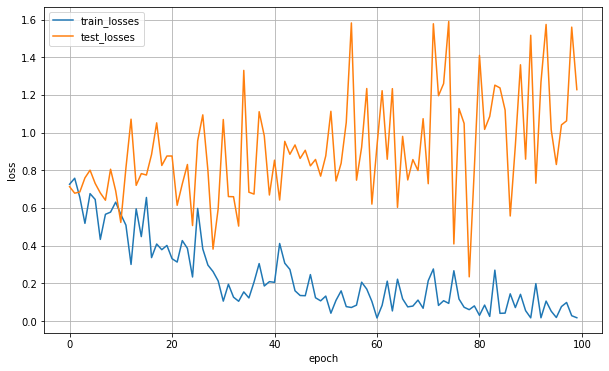

In [67]:
# Codeblock 26
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

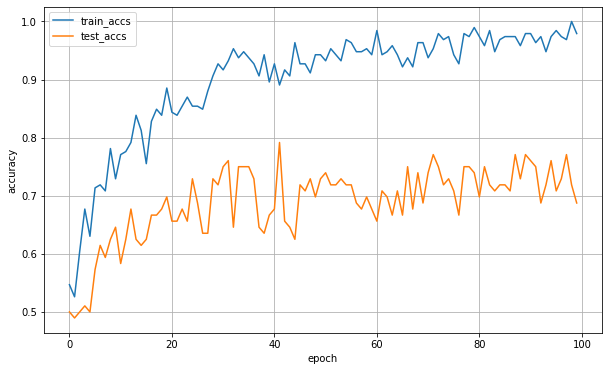

In [68]:
# Codeblock 27
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

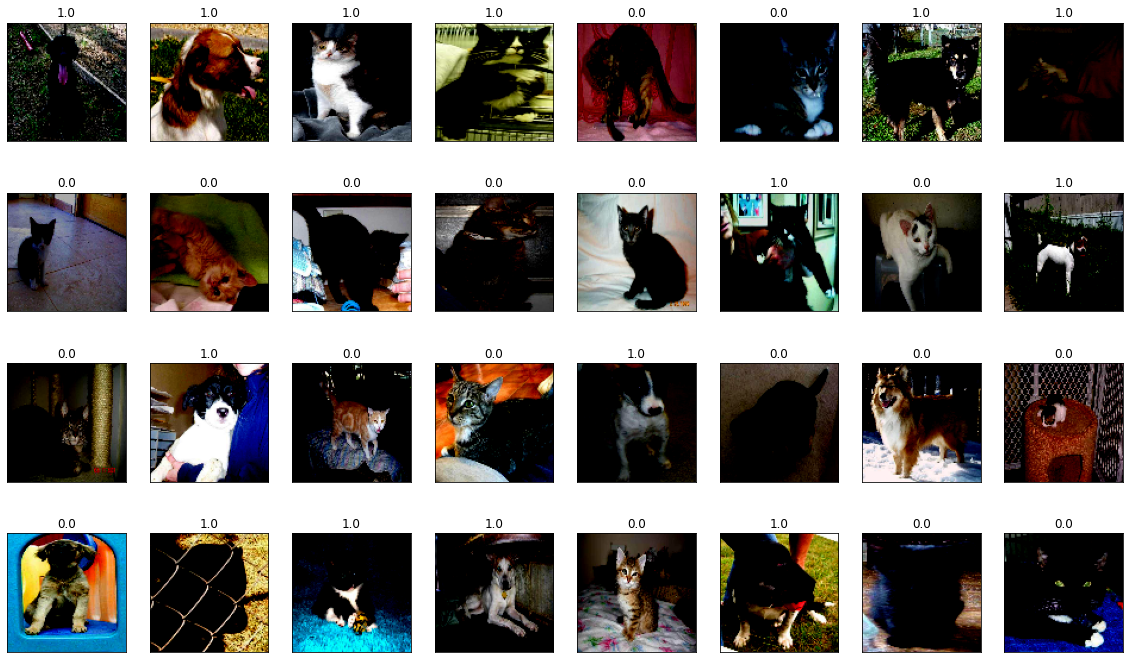

In [69]:
# Codeblock 28

# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)